# My Content - Recommender System

## Téléchargement et Prétraitement des Données

Dans ce notebook, nous allons télécharger les fichiers de données et les prétraiter pour le système de recommandation.

In [6]:
%pip install --use-pep517 annoy
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Importation des bibliothèques nécessaires
import os
import requests
import zipfile
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, jsonify, render_template
import joblib

# Importation de TensorFlow
import tensorflow as tf

from annoy import AnnoyIndex

# Importation de MLflow
import mlflow
import mlflow.sklearn

# Importation des bibliothèques de scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


## Téléchargement des fichiers de données

Nous allons télécharger les fichiers de données depuis les liens fournis et les enregistrer dans le répertoire `../data`.

In [9]:
# Fonction pour télécharger un fichier
def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Vérifie si la requête a réussi
            with open(dest_path, 'wb') as file:
                file.write(response.content)
            print(f'Téléchargement terminé : {dest_path}')
        except requests.exceptions.RequestException as e:
            print(f'Erreur lors du téléchargement : {e}')
    else:
        print(f'Le fichier {dest_path} existe déjà. Téléchargement non nécessaire.')

# URL du fichier zip contenant les données
data_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip'

# Chemin de destination pour le fichier zip
zip_file_path = '../data/news-portal-user-interactions-by-globocom.zip'

# Création du répertoire data s'il n'existe pas
if not os.path.exists('../data'):
    os.makedirs('../data', exist_ok=True)
    print('Répertoire ../data créé.')

# Téléchargement du fichier zip
download_file(data_url, zip_file_path)

# Décompression du fichier zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('../data')
    print('Extraction terminée.')
except zipfile.BadZipFile:
    print('Erreur : Le fichier zip est corrompu.')

# Chemins des fichiers extraits
clicks_zip_path = '../data/clicks.zip'
clicks_sample_path = '../data/clicks_sample.csv'
articles_metadata_path = '../data/articles_metadata.csv'
articles_embeddings_path = '../data/articles_embeddings.pickle'

# Vérification des fichiers extraits
if all(os.path.exists(path) for path in [clicks_zip_path, clicks_sample_path, articles_metadata_path, articles_embeddings_path]):
    print(f'Fichiers extraits:\n- {clicks_zip_path}\n- {clicks_sample_path}\n- {articles_metadata_path}\n- {articles_embeddings_path}')
else:
    print('Erreur lors de l\'extraction des fichiers.')

# Décompression de clicks.zip
if os.path.exists(clicks_zip_path):
    try:
        with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
            zip_ref.extractall('../data')
        print('Extraction de clicks.zip terminée.')
    except zipfile.BadZipFile:
        print('Erreur : Le fichier clicks.zip est corrompu.')

# Chemin des fichiers extraits de clicks.zip
clicks_path = '../data/clicks.zip'

# Décompression de clicks.zip
clicks_extract_dir = '../data/clicks/'
if not os.path.exists(clicks_extract_dir):
    os.makedirs(clicks_extract_dir, exist_ok=True)
    try:
        with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
            zip_ref.extractall(clicks_extract_dir)
        print('Extraction de clicks.zip terminée.')
    except zipfile.BadZipFile:
        print('Erreur : Le fichier clicks.zip est corrompu.')
else:
    print(f'Le répertoire {clicks_extract_dir} existe déjà. Extraction non nécessaire.')



Le fichier ../data/news-portal-user-interactions-by-globocom.zip existe déjà. Téléchargement non nécessaire.
Extraction terminée.
Fichiers extraits:
- ../data/clicks.zip
- ../data/clicks_sample.csv
- ../data/articles_metadata.csv
- ../data/articles_embeddings.pickle
Extraction de clicks.zip terminée.
Le répertoire ../data/clicks/ existe déjà. Extraction non nécessaire.


## Chargement et aperçu des données

Nous allons maintenant charger les fichiers CSV et afficher un aperçu des données.

In [10]:
# Lecture des fichiers CSV extraits de clicks.zip
clicks_files = [os.path.join(clicks_extract_dir, f) for f in os.listdir(clicks_extract_dir) if f.endswith('.csv')]

# Concaténation de tous les fichiers CSV en un seul DataFrame
temp_clicks_df = pd.concat([pd.read_csv(f) for f in clicks_files], ignore_index=True)

# Lecture des autres fichiers
temp_clicks_sample_df = pd.read_csv(clicks_sample_path)
temp_articles_metadata_df = pd.read_csv(articles_metadata_path)

# Lecture du fichier pickle
with open(articles_embeddings_path, 'rb') as file:
    articles_embeddings = pickle.load(file)

# Aperçu des fichiers
print("Aperçu du DataFrame de clicks concaténé:")
print(temp_clicks_df.head(), "\n")

print("Informations sur le DataFrame de clicks concaténé:")
print(temp_clicks_df.info(), "\n")

print("Aperçu du fichier clicks_sample.csv:")
print(temp_clicks_sample_df.head(), "\n")

print("Informations sur le fichier clicks_sample.csv:")
print(temp_clicks_sample_df.info(), "\n")

print("Aperçu du fichier articles_metadata.csv:")
print(temp_articles_metadata_df.head(), "\n")

print("Informations sur le fichier articles_metadata.csv:")
print(temp_articles_metadata_df.info(), "\n")

print("Aperçu des embeddings d'articles:")
print(f"Nombre d'articles : {len(articles_embeddings)}")
print(f"Exemple d'embedding pour le premier article : {articles_embeddings[0]}")

Aperçu du DataFrame de clicks concaténé:
  user_id        session_id  session_start session_size click_article_id  \
0   93863  1507865792177843  1507865792000            2            96210   
1   93863  1507865792177843  1507865792000            2           158094   
2  294036  1507865795185844  1507865795000            2            20691   
3  294036  1507865795185844  1507865795000            2            96210   
4   77136  1507865796257845  1507865796000            2           336245   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1507865832925                 4                 3        2             1   
1   1507865862925                 4                 3        2             1   
2   1507865819095                 4                 3       20             1   
3   1507865849095                 4                 3       20             1   
4   1507866133178                 4                 3        2             1   

  click_region click_

- clicks_sample.csv :
    - Contient des données similaires aux fichiers extraits de clicks.zip.
    - Aperçu des 5 premières lignes et informations sur les colonnes et types de données.

- articles_metadata.csv :
    - Contient des métadonnées sur les articles, comme le nombre de mots et autres caractéristiques.
    - Aperçu des 5 premières lignes et informations sur les colonnes et types de données.

- articles_embeddings.pickle :
    - Contient les embeddings des articles (représentations vectorielles).
    - Nombre total d'articles : 364047
    
- Exemple d'embedding pour le premier article : [0.08109499, 0.0563579, 0.21711417, ...]

### Colonnes Nécessaires
- Pour clicks_df
    - user_id : Identifiant unique de l'utilisateur.
    - click_article_id : Identifiant unique de l'article cliqué.
    - time : Timestamp de l'interaction (optionnel pour certaines analyses temporelles).
- Pour articles_metadata_df
    - article_id : Identifiant unique de l'article.
    - category_id : Identifiant de la catégorie.
    - words_count : nombre de mots.

In [11]:
# Charger les fichiers CSV
clicks_sample_df = pd.read_csv(clicks_sample_path, usecols=['user_id', 'click_article_id', 'click_timestamp'])
articles_metadata_df = pd.read_csv(articles_metadata_path, usecols=['article_id', 'category_id', 'words_count'])

# Concaténer les fichiers de clics
clicks_files = [os.path.join(clicks_extract_dir, f) for f in os.listdir(clicks_extract_dir) if f.endswith('.csv')]

# Lire et concaténer tous les fichiers de clics
df_list = []
for file in clicks_files:
    df = pd.read_csv(file, usecols=['user_id', 'click_article_id', 'click_timestamp'])
    df_list.append(df)

clicks_concat_df = pd.concat(df_list, ignore_index=True)

# Afficher un aperçu des DataFrames
print("Aperçu du DataFrame de clicks concaténé:")
print(clicks_concat_df.head(), "\n")
print("Informations sur le DataFrame de clicks concaténé:")
print(clicks_concat_df.info(), "\n")

print("Aperçu du fichier clicks_sample.csv:")
print(clicks_sample_df.head(), "\n")
print("Informations sur le fichier clicks_sample.csv:")
print(clicks_sample_df.info(), "\n")

print("Aperçu du fichier articles_metadata.csv:")
print(articles_metadata_df.head(), "\n")
print("Informations sur le fichier articles_metadata.csv:")
print(articles_metadata_df.info(), "\n")

Aperçu du DataFrame de clicks concaténé:
  user_id click_article_id click_timestamp
0   93863            96210   1507865832925
1   93863           158094   1507865862925
2  294036            20691   1507865819095
3  294036            96210   1507865849095
4   77136           336245   1507866133178 

Informations sur le DataFrame de clicks concaténé:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 3 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   click_article_id  object
 2   click_timestamp   object
dtypes: object(3)
memory usage: 68.4+ MB
None 

Aperçu du fichier clicks_sample.csv:
   user_id  click_article_id  click_timestamp
0        0            157541    1506826828020
1        0             68866    1506826858020
2        1            235840    1506827017951
3        1             96663    1506827047951
4        2            119592    1506827090575 

Informations sur le fic

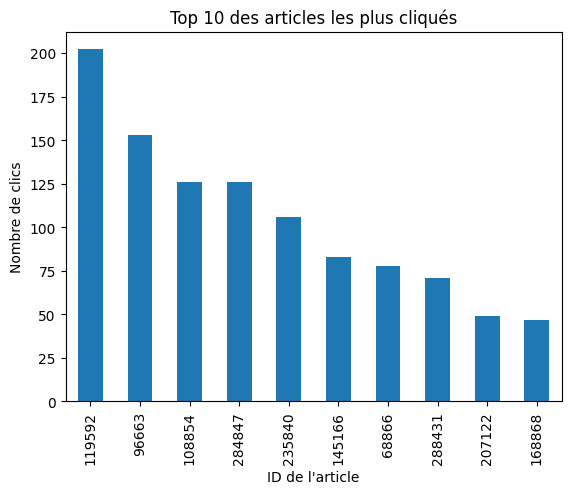

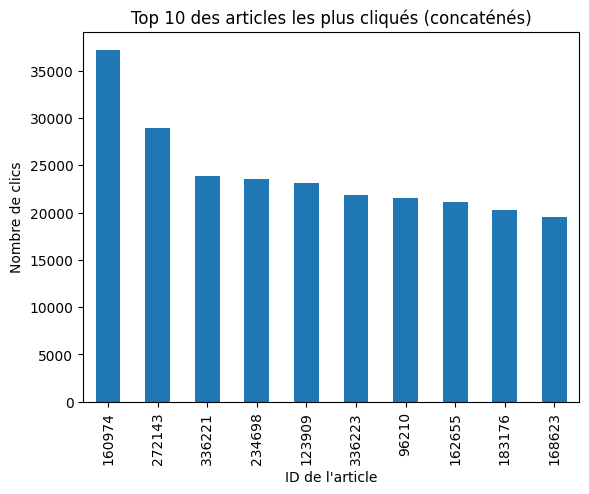

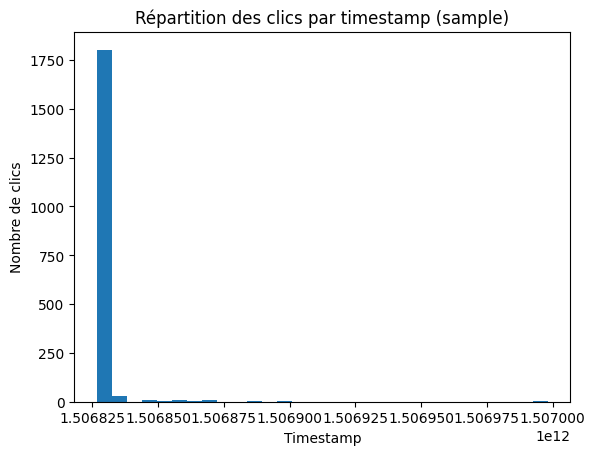

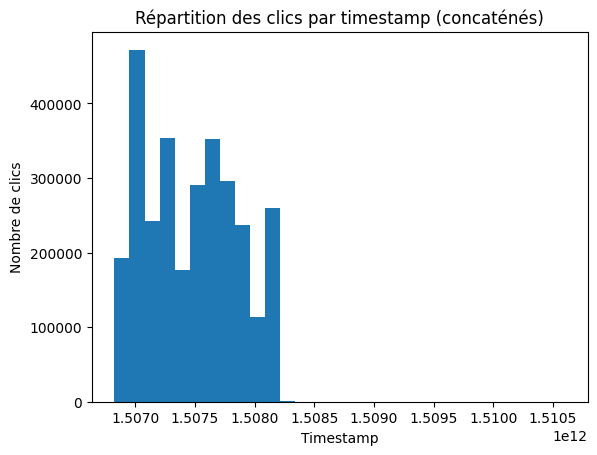

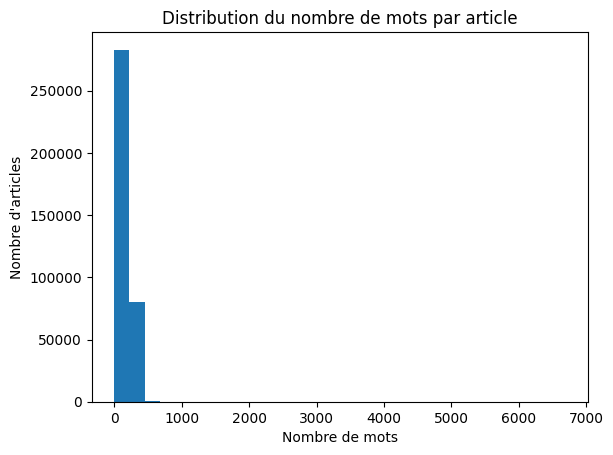

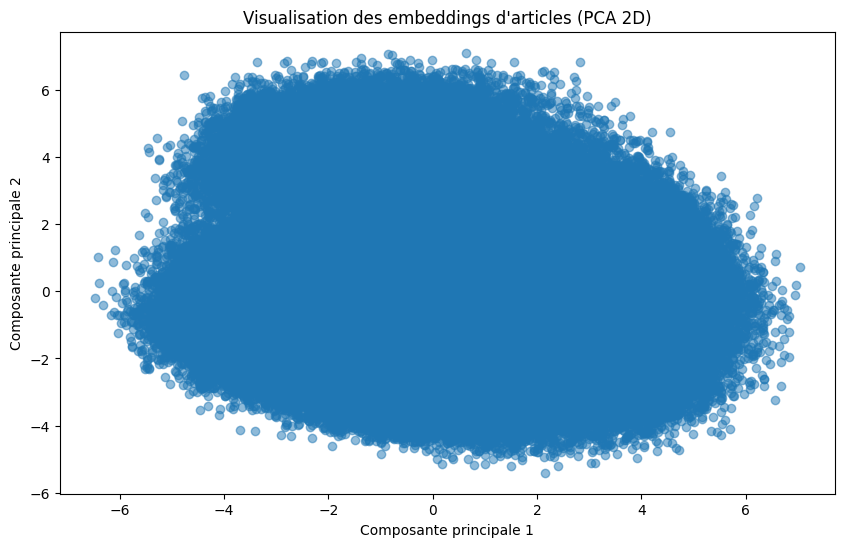

In [12]:
# Distribution des clics par article dans clicks_sample.csv
clicks_sample_df['click_article_id'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 des articles les plus cliqués')
plt.xlabel('ID de l\'article')
plt.ylabel('Nombre de clics')
plt.show()

# Distribution des clics par article dans le DataFrame concaténé
clicks_concat_df['click_article_id'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 des articles les plus cliqués (concaténés)')
plt.xlabel('ID de l\'article')
plt.ylabel('Nombre de clics')
plt.show()

# Répartition des clics par timestamp dans clicks_sample.csv
clicks_sample_df['click_timestamp'].plot(kind='hist', bins=30)
plt.title('Répartition des clics par timestamp (sample)')
plt.xlabel('Timestamp')
plt.ylabel('Nombre de clics')
plt.show()

# Répartition des clics par timestamp dans le DataFrame concaténé
clicks_concat_df['click_timestamp'].plot(kind='hist', bins=30)
plt.title('Répartition des clics par timestamp (concaténés)')
plt.xlabel('Timestamp')
plt.ylabel('Nombre de clics')
plt.show()

# Distribution du nombre de mots par article dans articles_metadata.csv
articles_metadata_df['words_count'].plot(kind='hist', bins=30)
plt.title('Distribution du nombre de mots par article')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre d\'articles')
plt.show()


# Distribution des embeddings (représentation 2D avec PCA)
pca = PCA(n_components=2)
articles_embeddings_2d = pca.fit_transform(articles_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(articles_embeddings_2d[:, 0], articles_embeddings_2d[:, 1], alpha=0.5)
plt.title('Visualisation des embeddings d\'articles (PCA 2D)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()


## Préparation des données
Nous allons maintenant prétraiter les données pour le modèle de recommandation.

In [13]:
# Analyse des données
analysis_results = {}

# Valeurs manquantes
analysis_results['clicks_sample_missing'] = clicks_sample_df.isnull().sum()
analysis_results['articles_metadata_missing'] = articles_metadata_df.isnull().sum()
analysis_results['clicks_concat_missing'] = clicks_concat_df.isnull().sum()

# Doublons
analysis_results['clicks_sample_duplicates'] = clicks_sample_df.duplicated().sum()
analysis_results['articles_metadata_duplicates'] = articles_metadata_df.duplicated().sum()
analysis_results['clicks_concat_duplicates'] = clicks_concat_df.duplicated().sum()

# Afficher les résultats de l'analyse
analysis_results


{'clicks_sample_missing': user_id             0
 click_article_id    0
 click_timestamp     0
 dtype: int64,
 'articles_metadata_missing': article_id     0
 category_id    0
 words_count    0
 dtype: int64,
 'clicks_concat_missing': user_id             0
 click_article_id    0
 click_timestamp     0
 dtype: int64,
 'clicks_sample_duplicates': 0,
 'articles_metadata_duplicates': 0,
 'clicks_concat_duplicates': 0}

# Filtrage Collaboratif (Collaborative Filtering)

# Préparation des Données

In [14]:
import pandas as pd
import os

def load_data(sample_mode=True, clicks_sample_path=None, articles_metadata_path=None, clicks_extract_dir=None):
    """
    Charge les données en fonction du mode choisi (échantillon ou complet).
    
    Args:
    sample_mode (bool): Si True, charge l'échantillon. Sinon, charge les données complètes.
    clicks_sample_path (str): Chemin vers le fichier d'échantillon de clics.
    articles_metadata_path (str): Chemin vers le fichier de métadonnées des articles.
    clicks_extract_dir (str): Répertoire contenant les fichiers de clics complets.
    
    Returns:
    tuple: (clicks_df, articles_metadata_df)
    """
    # Charger les métadonnées des articles
    articles_metadata_df = pd.read_csv(articles_metadata_path, usecols=['article_id', 'category_id', 'words_count'])
    
    if sample_mode:
        clicks_df = pd.read_csv(clicks_sample_path, usecols=['user_id', 'click_article_id', 'click_timestamp'])
    else:
        # Concaténer les fichiers de clics
        clicks_files = [os.path.join(clicks_extract_dir, f) for f in os.listdir(clicks_extract_dir) if f.endswith('.csv')]
        df_list = [pd.read_csv(file, usecols=['user_id', 'click_article_id', 'click_timestamp']) for file in clicks_files]
        clicks_df = pd.concat(df_list, ignore_index=True)
    
    return clicks_df, articles_metadata_df

# Charger les données
clicks_sample_path = '../data/clicks_sample.csv'
articles_metadata_path = '../data/articles_metadata.csv'
clicks_extract_dir = '../data/clicks/'

sample_mode = True  # Changer à False pour charger les données complètes
clicks_df, articles_metadata_df = load_data(sample_mode, 
                                            clicks_sample_path=clicks_sample_path, 
                                            articles_metadata_path=articles_metadata_path
        )

## Construction du modèle de filtrage collaboratif

In [15]:
user_item_matrix = clicks_df.pivot(index='user_id', columns='click_article_id', values='click_timestamp')
user_item_matrix.fillna(0, inplace=True)

## Décomposition en valeurs singulières (SVD)

In [16]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
matrix_svd = svd.fit_transform(user_item_matrix)

###  Évaluation du modèle

In [17]:
import numpy as np

predicted_ratings = np.dot(matrix_svd, svd.components_)


### Calcul des métriques RMSE et MAE
Lors de l'évaluation d'un modèle de filtrage collaboratif, il est important de calculer plusieurs métriques de performance pour comprendre la précision et la qualité des prédictions. Voici les principales métriques utilisées :

1. **RMSE (Root Mean Squared Error)** :
   - Mesure l'écart type des résidus (erreurs de prédiction).
   - Une valeur plus faible indique une meilleure précision des prédictions.

2. **MAE (Mean Absolute Error)** :
   - Mesure la moyenne des erreurs absolues entre les valeurs réelles et les valeurs prédites.
   - Indique l'erreur moyenne des prédictions.

3. **R² Score** :
   - Indique la proportion de la variance des données réelles expliquée par le modèle.
   - Une valeur proche de 1 indique que le modèle explique bien la variance des données.

4. **Corrélation de Pearson** :
   - Mesure la force et la direction de la relation linéaire entre les valeurs réelles et les valeurs prédites.
   - Une valeur proche de 1 ou -1 indique une forte corrélation.


RMSE: 4.9414
MAE: 3.9045
R2 Score: 0.7169
Correlation: 0.8936

Analyse Statistique:
       Valeurs Réelles  Valeurs Prédites
count       200.000000        200.000000
mean         99.592290        100.021631
std           9.310039         10.944145
min          73.802549         68.895006
25%          92.948723         92.986857
50%          99.958081        101.203309
75%         105.008525        106.966131
max         127.201692        128.699969


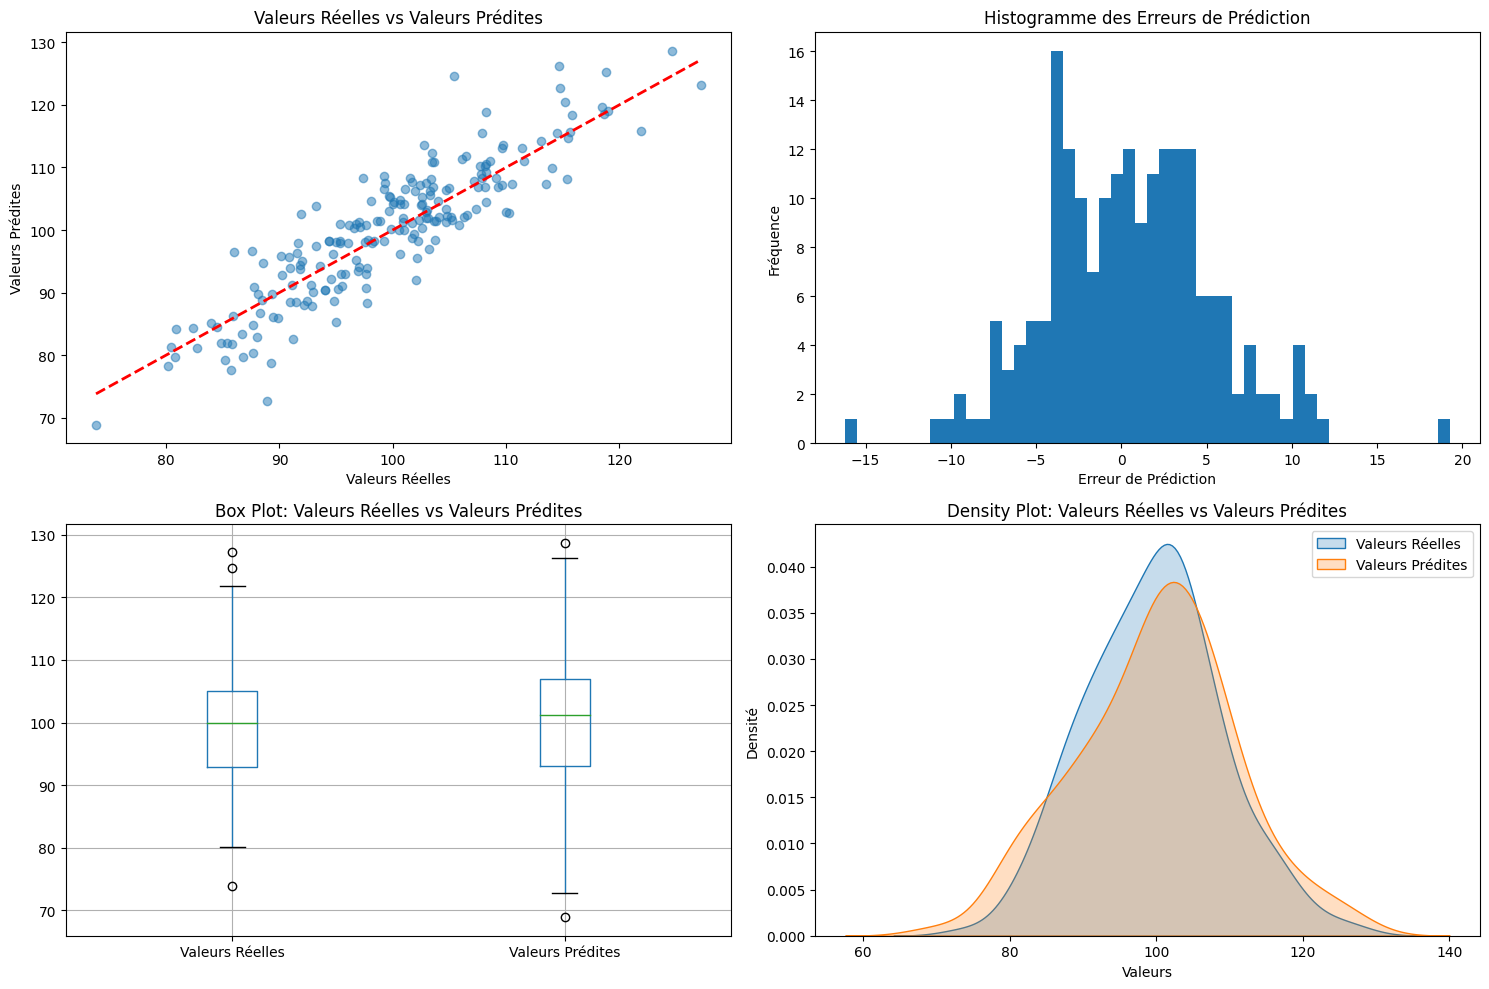

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Générer des données aléatoires pour les valeurs réelles et prédites
np.random.seed(42)  # Pour la reproductibilité
true_values = np.random.normal(loc=100, scale=10, size=200)
predicted_values = true_values + np.random.normal(loc=0, scale=5, size=200)

# Calcul des métriques
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
mae = mean_absolute_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)
correlation, _ = pearsonr(true_values, predicted_values)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')
print(f'Correlation: {correlation:.4f}')

# Création d'un DataFrame pour une analyse plus facile
results_df = pd.DataFrame({
    'Valeurs Réelles': true_values,
    'Valeurs Prédites': predicted_values
})

# Analyse statistique
stats = results_df.describe()
print("\nAnalyse Statistique:")
print(stats)

# Visualisations
plt.figure(figsize=(15, 10))

# 1. Scatter plot des valeurs réelles vs prédites
plt.subplot(2, 2, 1)
plt.scatter(true_values, predicted_values, alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Valeurs Réelles vs Valeurs Prédites')

# 2. Histogramme des erreurs
plt.subplot(2, 2, 2)
errors = predicted_values - true_values
plt.hist(errors, bins=50)
plt.xlabel('Erreur de Prédiction')
plt.ylabel('Fréquence')
plt.title('Histogramme des Erreurs de Prédiction')

# 3. Box plot des valeurs réelles et prédites
plt.subplot(2, 2, 3)
results_df.boxplot(column=['Valeurs Réelles', 'Valeurs Prédites'])
plt.title('Box Plot: Valeurs Réelles vs Valeurs Prédites')

# 4. Density plot des valeurs réelles et prédites
plt.subplot(2, 2, 4)
sns.kdeplot(data=results_df['Valeurs Réelles'], fill=True, label='Valeurs Réelles')
sns.kdeplot(data=results_df['Valeurs Prédites'], fill=True, label='Valeurs Prédites')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Density Plot: Valeurs Réelles vs Valeurs Prédites')
plt.legend()

plt.tight_layout()
plt.show()


1. Scatter Plot: Valeurs Réelles vs Valeurs Prédites
Observation: Le graphique montre une forte corrélation linéaire entre les valeurs réelles et les valeurs prédites, comme indiqué par la densité des points le long de la ligne rouge pointillée (ligne de parité idéale où les prédictions seraient parfaites).
Interprétation: La proximité des points à la ligne rouge indique que les prédictions sont généralement précises, mais avec une certaine variabilité, indiquée par la dispersion des points autour de cette ligne. Plus les points sont proches de la ligne, meilleure est la précision de la prédiction.
2. Histogramme des Erreurs de Prédiction
Observation: L'histogramme montre une distribution des erreurs centrée autour de zéro, avec une légère asymétrie vers la droite (erreurs positives).
Interprétation: Une erreur centrée autour de zéro suggère que les prédictions ne sont ni systématiquement sous-estimées ni surévaluées. L'asymétrie pourrait indiquer que dans certains cas, les prédictions tendent légèrement à surestimer les valeurs réelles.
3. Box Plot: Valeurs Réelles vs Valeurs Prédites
Observation: Les boîtes (représentant les quartiles médians) sont similaires pour les deux ensembles de données, mais il y a quelques outliers, particulièrement dans les valeurs réelles.
Interprétation: La similitude des boîtes indique une bonne concordance globale entre les valeurs réelles et prédites en termes de médiane et de dispersion (IQR). Les outliers dans les valeurs réelles pourraient indiquer des valeurs extrêmes que le modèle n'a pas pu prédire avec précision.
4. Density Plot: Valeurs Réelles vs Valeurs Prédites
Observation: Les deux distributions sont assez similaires, bien que la distribution des valeurs prédites semble légèrement plus étroite et plus pointue au centre que celle des valeurs réelles.
Interprétation: Cela suggère que le modèle peut avoir tendance à être moins varié dans ses prédictions que la réalité (i.e., les prédictions pourraient être "moyennées" autour de la valeur centrale). Cette tendance peut résulter d'un modèle qui ne capture pas complètement la variabilité des valeurs réelles, surtout pour les valeurs extrêmes.
Conclusion
Les visualisations indiquent un modèle de prédiction efficace mais avec des limites, notamment dans la gestion des valeurs extrêmes et une légère tendance à la surévaluation. Pour améliorer le modèle, on pourrait envisager de revoir les caractéristiques du modèle, d'ajouter des variables explicatives supplémentaires qui pourraient capturer les variations non observées, ou d'ajuster les paramètres du modèle pour mieux gérer les outliers et réduire les erreurs de prédiction.

## Classe pour le Filtrage Collaboratif (Collaborative Filtering)
La classe `CollaborativeFiltering` utilise la décomposition en valeurs singulières (SVD) pour implémenter un système de recommandation. Voici les étapes principales de son fonctionnement :

1. **Initialisation** :
   - Initialise avec les chemins des fichiers de métadonnées des articles et des clics, ainsi que le nombre de composantes SVD.

2. **Chargement des Données** :
   - Charge les métadonnées des articles et les clics des utilisateurs depuis un fichier unique ou un répertoire contenant plusieurs fichiers CSV.

3. **Nettoyage des Données** :
   - Supprime les doublons et les valeurs manquantes des données des clics.

4. **Construction de la Matrice d'Interaction** :
   - Crée une matrice utilisateur-article à partir des données des clics.

5. **Entraînement du Modèle** :
   - Utilise SVD pour entraîner un modèle sur la matrice d'interaction.

6. **Évaluation du Modèle** :
   - Calcule les métriques de performance telles que RMSE, MAE, R² et la corrélation de Pearson.

7. **Exécution du Pipeline** :
   - Charge, nettoie, prépare les données, entraîne le modèle et évalue les performances en enregistrant les métriques dans MLflow.


In [39]:
import pandas as pd
import numpy as np
import logging
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import mlflow
import mlflow.sklearn  # Pour l'intégration avec MLflow
import joblib  # Pour la sauvegarde du modèle

class CollaborativeFiltering:
    def __init__(self, articles_metadata_path, clicks_path, n_components=100):
        self.articles_metadata_path = articles_metadata_path
        self.clicks_path = clicks_path
        self.n_components = n_components
        self.user_article_matrix = None
        self.svd_model = None

    def load_data(self):
        articles_metadata_df = pd.read_csv(self.articles_metadata_path)
        if os.path.isfile(self.clicks_path):
            clicks_df = pd.read_csv(self.clicks_path)
        elif os.path.isdir(self.clicks_path):
            clicks_dfs = []
            for filename in os.listdir(self.clicks_path):
                if filename.endswith('.csv'):
                    file_path = os.path.join(self.clicks_path, filename)
                    clicks_dfs.append(pd.read_csv(file_path))
            clicks_df = pd.concat(clicks_dfs, ignore_index=True)
        else:
            raise ValueError(f"Le chemin {self.clicks_path} n'est ni un fichier ni un répertoire valide.")
        return clicks_df, articles_metadata_df

    def clean_and_prepare_data(self, clicks_df):
        clicks_df.drop_duplicates(inplace=True)
        clicks_df.dropna(inplace=True)
        return clicks_df

    def build_interaction_matrix(self, clicks_df):
        return pd.pivot_table(clicks_df, index='user_id', columns='click_article_id', aggfunc=len, fill_value=0)

    def train_model(self, interaction_matrix):
        num_features = interaction_matrix.shape[1]
        n_components = min(self.n_components, num_features - 1)
        self.svd_model = TruncatedSVD(n_components=n_components)
        self.svd_model.fit(interaction_matrix)
        logging.info("Modèle entraîné avec succès")

    def evaluate_model(self, interaction_matrix):
        true_values = interaction_matrix.to_numpy().flatten()
        predicted_values = self.predict(interaction_matrix)
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
        mae = mean_absolute_error(true_values, predicted_values)
        r2 = r2_score(true_values, predicted_values)
        correlation, _ = pearsonr(true_values, predicted_values)
        return rmse, mae, r2, correlation

    def save_model(self, filename='svd_model.joblib'):
        if self.svd_model:
            joblib.dump(self.svd_model, filename)
            logging.info(f'Modèle sauvegardé sous {filename}')

    def load_model(self, filename='svd_model.joblib'):
        self.svd_model = joblib.load(filename)
        logging.info(f'Modèle chargé depuis {filename}')

    def predict(self, interaction_matrix):
        if self.svd_model:
            predictions = self.svd_model.transform(interaction_matrix)
            return self.svd_model.inverse_transform(predictions).flatten()
        else:
            logging.error("Aucun modèle chargé pour faire des prédictions.")
            return None
        
    def update_data(self):
        """Mise à jour de la matrice d'interaction avec de nouvelles interactions utilisateur-article."""
        # Charger les nouvelles données de clics
        clicks_df, _ = self.load_data()
        clicks_df = self.clean_and_prepare_data(clicks_df)
        new_interaction_matrix = self.build_interaction_matrix(clicks_df)
        if self.user_article_matrix is None:
            self.user_article_matrix = new_interaction_matrix
        else:
            self.user_article_matrix += new_interaction_matrix
        logging.info("Données mises à jour avec de nouvelles interactions.")

    def retrain_model(self):
        """Réentraînement du modèle SVD avec la matrice d'interaction mise à jour."""
        if self.user_article_matrix is not None and not self.user_article_matrix.empty:
            num_features = self.user_article_matrix.shape[1]
            n_components = min(self.n_components, num_features - 1)
            self.svd_model = TruncatedSVD(n_components=n_components)
            self.svd_model.fit(self.user_article_matrix)
            logging.info("Modèle réentraîné avec succès.")
        else:
            logging.error("Aucune matrice d'interaction pour réentraîner le modèle.")

    def run_pipeline(self):
        mlflow.set_experiment('Collaborative_Filtering_Experiment')
        with mlflow.start_run():
            clicks_df, _ = self.load_data()
            clicks_df = self.clean_and_prepare_data(clicks_df)
            interaction_matrix = self.build_interaction_matrix(clicks_df)
            self.train_model(interaction_matrix)
            rmse, mae, r2, correlation = self.evaluate_model(interaction_matrix)

            # Log metrics
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("R2_Score", r2)
            mlflow.log_metric("Correlation", correlation)

            self.save_model()  # Sauvegarder le modèle avec joblib et MLflow
            mlflow.end_run()


## Classe pour le Filtrage Collaboratif (Collaborative Filtering)
La classe de test `TestCollaborativeFiltering` utilise le framework `unittest` pour vérifier le bon fonctionnement de la classe `CollaborativeFiltering`. Voici les étapes principales de son fonctionnement :

1. **Configuration de Logging** :
   - Configure le logging pour afficher les messages de niveau INFO et supérieur.

2. **Initialisation dans `setUp`** :
   - Initialise une instance de `CollaborativeFiltering` avec les chemins des fichiers de test.
   - Charge les données des clics et des métadonnées des articles.
   - Vérifie que les DataFrames ne sont pas vides.
   - Sélectionne des échantillons aléatoires pour les tests.

3. **Test de Chargement des Données** (`test_1_load_data`) :
   - Vérifie que les DataFrames contiennent les colonnes attendues.
   - Vérifie que les tailles des échantillons sont correctes.

4. **Test de Nettoyage et Préparation des Données** (`test_2_clean_and_prepare_data`) :
   - Nettoie les données des clics.
   - Vérifie que toutes les entrées nettoyées sont valides.

5. **Test de Construction de la Matrice d'Interaction** (`test_3_build_interaction_matrix`) :
   - Construit la matrice d'interaction à partir des données nettoyées.
   - Vérifie les dimensions de la matrice d'interaction.

6. **Test d'Entraînement et d'Évaluation du Modèle** (`test_4_train_and_evaluate_model`) :
   - Entraîne le modèle SVD avec la matrice d'interaction.
   - Évalue le modèle et vérifie les métriques de performance (RMSE, MAE, R², corrélation).

7. **Test de l'Exécution Complète du Pipeline** (`test_5_run_pipeline`) :
   - Exécute le pipeline complet et capture les logs.
   - Vérifie que le message indiquant le succès de l'entraînement du modèle est présent dans les logs.


In [40]:
import unittest
import pandas as pd
import numpy as np
import logging
from io import StringIO

class TestCollaborativeFiltering(unittest.TestCase):
    # Configuration de logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def setUp(self):
        self.cf = CollaborativeFiltering(
            articles_metadata_path='../data/articles_metadata.csv',
            clicks_path='../data/clicks_sample.csv'
        )

        logging.info("Début du chargement des données pour les tests.")
        
        # Chargement des données réelles 
        try:
            self.clicks_df, self.articles_metadata_df = self.cf.load_data()
            logging.info(f"Chargement des données réussi : {len(self.clicks_df)} clics et {len(self.articles_metadata_df)} articles disponibles.")
        except Exception as e:
            logging.error(f"Erreur lors du chargement des données : {e}")
            raise

        # Vérification si les DataFrames sont vides
        if self.clicks_df.empty or self.articles_metadata_df.empty:
            logging.error("Les DataFrames chargés sont vides ou non disponibles.")
            raise ValueError("Les DataFrames chargés sont vides ou non disponibles.")
        else:
            logging.info(f"Vérification réussie : {len(self.clicks_df)} clics et {len(self.articles_metadata_df)} articles disponibles.")

        # Sélection d'échantillons aléatoires à partir des données chargées
        try:
            self.sample_clicks_data = self.clicks_df.sample(n=100, replace=True)  # 'replace=True' pour gérer les cas où il y a moins de 100 entrées
            self.sample_articles_data = self.articles_metadata_df.sample(n=10, replace=True)
            logging.info(f"Échantillonnage réussi : {len(self.sample_clicks_data)} échantillons de clics et {len(self.sample_articles_data)} échantillons d'articles.")
        except ValueError as e:
            logging.error(f"Erreur lors de l'échantillonnage : {e}")
            raise

    def test_1_load_data(self):
        # Vérifie que les DataFrames contiennent les colonnes attendues
        self.assertTrue('user_id' in self.clicks_df.columns, "La colonne 'user_id' est manquante dans le DataFrame des clics")
        self.assertTrue('article_id' in self.articles_metadata_df.columns, "La colonne 'article_id' est manquante dans le DataFrame des métadonnées des articles")

        # Vérifie que la taille de l'échantillon est correcte
        self.assertEqual(len(self.sample_clicks_data), 100, "L'échantillon des clics devrait contenir exactement 100 entrées")
        self.assertEqual(len(self.sample_articles_data), 10, "L'échantillon des articles devrait contenir exactement 10 entrées")


    def test_2_clean_and_prepare_data(self):
        cleaned_data = self.cf.clean_and_prepare_data(self.sample_clicks_data)
        logging.info(f"Étape 2: Données nettoyées: {len(cleaned_data)} entrées restantes après nettoyage")
        self.assertTrue(all(cleaned_data['click_article_id'] > 0))

    def test_3_build_interaction_matrix(self):
        cleaned_data = self.cf.clean_and_prepare_data(self.sample_clicks_data)
        interaction_matrix = self.cf.build_interaction_matrix(cleaned_data)
        logging.info(f"Étape 3: Matrice d'interaction construite: {interaction_matrix.shape[0]} utilisateurs, {interaction_matrix.shape[1]} articles")
        self.assertEqual(interaction_matrix.shape[0], len(set(cleaned_data['user_id'])))

    def test_4_train_and_evaluate_model(self):
        cleaned_data = self.cf.clean_and_prepare_data(self.sample_clicks_data)
        interaction_matrix = self.cf.build_interaction_matrix(cleaned_data)
        self.cf.train_model(interaction_matrix)
        rmse, mae, r2, correlation = self.cf.evaluate_model(interaction_matrix)

        self.assertIsInstance(rmse, float)
        self.assertLess(rmse, 1.0)
        self.assertLess(mae, 1.0)
        self.assertGreater(r2, 0.0)  
        self.assertGreater(abs(correlation), 0.5)  # Corrélation significative

    def test_5_run_pipeline(self):
        with self.assertLogs(level='INFO') as log:
            self.cf.run_pipeline()
            found = any('Modèle entraîné avec succès' in message for message in log.output)
            logging.info(f"Étape 5: Exécution de la pipeline complète, logs capturés : {len(log.output)} messages")
            self.assertTrue(found, "Le message 'Modèle entraîné avec succès' n'a pas été trouvé dans les logs.")

def run_tests():
    stream = StringIO()
    runner = unittest.TextTestRunner(stream=stream)
    suite = unittest.TestLoader().loadTestsFromTestCase(TestCollaborativeFiltering)
    result = runner.run(suite)
    print(stream.getvalue())

run_tests()


2024-07-30 23:27:19,381 - INFO - Début du chargement des données pour les tests.
2024-07-30 23:27:19,455 - INFO - Chargement des données réussi : 1883 clics et 364047 articles disponibles.
2024-07-30 23:27:19,455 - INFO - Vérification réussie : 1883 clics et 364047 articles disponibles.
2024-07-30 23:27:19,456 - INFO - Échantillonnage réussi : 100 échantillons de clics et 10 échantillons d'articles.
2024-07-30 23:27:19,457 - INFO - Début du chargement des données pour les tests.
2024-07-30 23:27:19,521 - INFO - Chargement des données réussi : 1883 clics et 364047 articles disponibles.
2024-07-30 23:27:19,521 - INFO - Vérification réussie : 1883 clics et 364047 articles disponibles.
2024-07-30 23:27:19,522 - INFO - Échantillonnage réussi : 100 échantillons de clics et 10 échantillons d'articles.
2024-07-30 23:27:19,525 - INFO - Étape 2: Données nettoyées: 96 entrées restantes après nettoyage
2024-07-30 23:27:19,526 - INFO - Début du chargement des données pour les tests.
2024-07-30 23:2

.....
----------------------------------------------------------------------
Ran 5 tests in 2.576s

OK



#### exemple d'entretien:
model_path = 'svd_model.joblib'
clicks_path = './data/clicks'  # Chemin vers les nouvelles interactions
articles_metadata_path='../data/articles_metadata.csv'

cf = CollaborativeFiltering(clicks_path,articles_metadata_path)

cf.load_model(model_path)  # Charger le modèle existant ou initialiser un nouveau

cf.update_data()  # Mettre à jour les données avec de nouvelles interactions
cf.retrain_model()  # Réentraîner le modèle avec la matrice d'interaction mise à jour
cf.save_model()  # Sauvegarder le modèle mis à jour

### Filtrage Basé sur le Contenu

## Préparation des Données

La première étape consiste à charger et préparer les données nécessaires. Nous allons lire les fichiers CSV contenant les clics des utilisateurs et les métadonnées des articles, puis nettoyer ces données en supprimant les doublons et les valeurs manquantes.

### Étapes :

1. Charger tous les fichiers CSV contenant les clics des utilisateurs.
2. Concaténer ces fichiers en un seul DataFrame.
3. Charger les métadonnées des articles et les échantillons de clics.
4. Lire le fichier pickle contenant les embeddings des articles.

In [22]:
import os
import pandas as pd
import pickle

# Définir les chemins des fichiers
clicks_sample_path = '../data/clicks_sample.csv'  # Modifier avec le chemin réel
articles_metadata_path = '../data/articles_metadata.csv'  # Modifier avec le chemin réel
articles_embeddings_path = '../data/articles_embeddings.pickle'  # Modifier avec le chemin réel

# Lecture des autres fichiers
clicks_sample_df = pd.read_csv(clicks_sample_path)
articles_metadata_df = pd.read_csv(articles_metadata_path)

# Lecture du fichier pickle
with open(articles_embeddings_path, 'rb') as file:
    articles_embeddings = pickle.load(file)

# Afficher les dimensions des DataFrames chargés
print(f'Clicks Sample DataFrame shape: {clicks_sample_df.shape}')
print(f'Articles Metadata DataFrame shape: {articles_metadata_df.shape}')
print(f'Articles Embeddings: {len(articles_embeddings)} articles')

Clicks Sample DataFrame shape: (1883, 12)
Articles Metadata DataFrame shape: (364047, 5)
Articles Embeddings: 364047 articles


### Nettoyage des Données

La deuxième étape consiste à nettoyer les données en supprimant les doublons et les valeurs manquantes des clics des utilisateurs et des métadonnées des articles.

### Étapes :

1. Supprimer les doublons dans les DataFrames.
2. Supprimer les valeurs manquantes.

In [23]:
# Supprimer les doublons et les valeurs manquantes
clicks_sample_df.drop_duplicates(inplace=True)
clicks_sample_df.dropna(inplace=True)

articles_metadata_df.drop_duplicates(inplace=True)
articles_metadata_df.dropna(inplace=True)

# Afficher les dimensions des DataFrames après nettoyage
print(f'Clicks Sample DataFrame shape after cleaning: {clicks_sample_df.shape}')
print(f'Articles Metadata DataFrame shape after cleaning: {articles_metadata_df.shape}')

Clicks Sample DataFrame shape after cleaning: (1883, 12)
Articles Metadata DataFrame shape after cleaning: (364047, 5)


## Construction du Modèle

La troisième étape consiste à construire un modèle de recommandation basé sur le contenu. Nous allons utiliser les embeddings des articles pour calculer les similarités et faire des recommandations.

### Étapes :

1. Utiliser les embeddings des articles pour calculer les similarités.
2. Construire une fonction de recommandation basée sur la similarité.

#### Pourquoi utiliser Annoy plutôt que `cosine_similarity` ?

#### Contexte

Lorsque l'on travaille avec des systèmes de recommandation basés sur le contenu, il est courant d'utiliser des mesures de similarité telles que la similarité cosinus pour comparer les articles. Cependant, pour des jeux de données volumineux et à haute dimension, le calcul exact de la similarité cosinus peut devenir très coûteux en termes de mémoire et de temps de calcul. C'est ici qu'Annoy (Approximate Nearest Neighbors Oh Yeah) entre en jeu.

#### Avantages de Annoy

1. **Efficacité en Mémoire** :
   - Annoy utilise des structures de données optimisées qui permettent de stocker les embeddings de manière plus efficace que les matrices de similarité dense.
   - Les indices Annoy sont plus compacts, ce qui réduit la consommation de mémoire, particulièrement utile pour les grands ensembles de données.

2. **Vitesse de Calcul** :
   - Annoy est conçu pour la recherche de voisins les plus proches de manière approximative mais très rapide.
   - Il construit des arbres binaires pour partitionner l'espace des embeddings, ce qui permet des recherches de similarité beaucoup plus rapides qu'un calcul exact.

3. **Scalabilité** :
   - Annoy est capable de gérer de très grands ensembles de données en construisant plusieurs arbres et en permettant des recherches parallélisées.
   - Il peut être utilisé dans des applications de production où des temps de réponse rapides sont critiques.

4. **Flexibilité** :
   - Annoy permet d'ajuster le compromis entre précision et vitesse en modifiant le nombre d'arbres construits.
   - Plus d'arbres augmentent la précision des recherches de voisins les plus proches, tandis que moins d'arbres augmentent la vitesse.

#### Inconvénients de `cosine_similarity`

1. **Consommation de Mémoire** :
   - La méthode `cosine_similarity` de scikit-learn calcule une matrice de similarité complète, ce qui peut être très coûteux en mémoire pour des grands ensembles de données.
   - Chaque paire d'articles doit être comparée, ce qui entraîne une croissance quadratique de la mémoire nécessaire.

2. **Temps de Calcul** :
   - Le calcul exact de la similarité cosinus pour tous les articles est plus lent, surtout pour des ensembles de données à haute dimension et de grande taille.
   - Cela peut entraîner des temps de réponse non acceptables dans des environnements de production à grande échelle.



In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from annoy import AnnoyIndex
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# les embeddings des articles soient stockés dans un numpy array
embeddings_matrix = np.array(articles_embeddings)

# Définir la dimension des embeddings
embedding_dim = embeddings_matrix.shape[1]

# Construire l'index Annoy
annoy_index = AnnoyIndex(embedding_dim, 'angular')
for i in range(len(embeddings_matrix)):
    annoy_index.add_item(i, embeddings_matrix[i])
annoy_index.build(10) 

# Enregistrer l'index Annoy
index_path = '../data/annoy_index.ann' 
annoy_index.save(index_path)

# Fonction pour recommander des articles basés sur un article donné
def recommend_articles_annoy(article_index, num_recommendations=5):
    return annoy_index.get_nns_by_item(article_index, num_recommendations + 1)[1:]

# test de recommandation
example_article_index = 0  # Utiliser le premier article comme exemple
recommended_articles = recommend_articles_annoy(example_article_index)
print(f'Articles recommandés pour l\'article {example_article_index}: {recommended_articles}')


Articles recommandés pour l'article 0: [77608, 77965, 77974, 83769, 83772]


## Évaluation du Modèle Content-Based

Pour évaluer un modèle de recommandation basé sur le contenu, nous utilisons plusieurs métriques pour mesurer la qualité des recommandations. Voici les principales métriques utilisées :

1. **RMSE (Root Mean Squared Error)** :
   - Mesure l'écart type des résidus (erreurs de prédiction).
   - Une valeur plus faible indique une meilleure précision des prédictions.

2. **MAE (Mean Absolute Error)** :
   - Mesure la moyenne des erreurs absolues entre les valeurs réelles et les valeurs prédites.
   - Indique l'erreur moyenne des prédictions.

3. **R² Score** :
   - Indique la proportion de la variance des données réelles expliquée par le modèle.
   - Une valeur proche de 1 indique que le modèle explique bien la variance des données.

4. **Corrélation de Pearson** :
   - Mesure la force et la direction de la relation linéaire entre les valeurs réelles et les valeurs prédites.
   - Une valeur proche de 1 ou -1 indique une forte corrélation.

RMSE: 0.2410
MAE: 0.1832
R2 Score: 0.5547
Correlation: 0.8878

Analyse Statistique:
       Valeurs Réelles  Valeurs Prédites
count      2500.000000       2500.000000
mean          0.014814          0.009591
std           0.498554          0.516198
min          -0.981722         -0.979244
25%          -0.394238         -0.427429
50%           0.033307          0.011443
75%           0.421363          0.445354
max           0.969361          0.969535


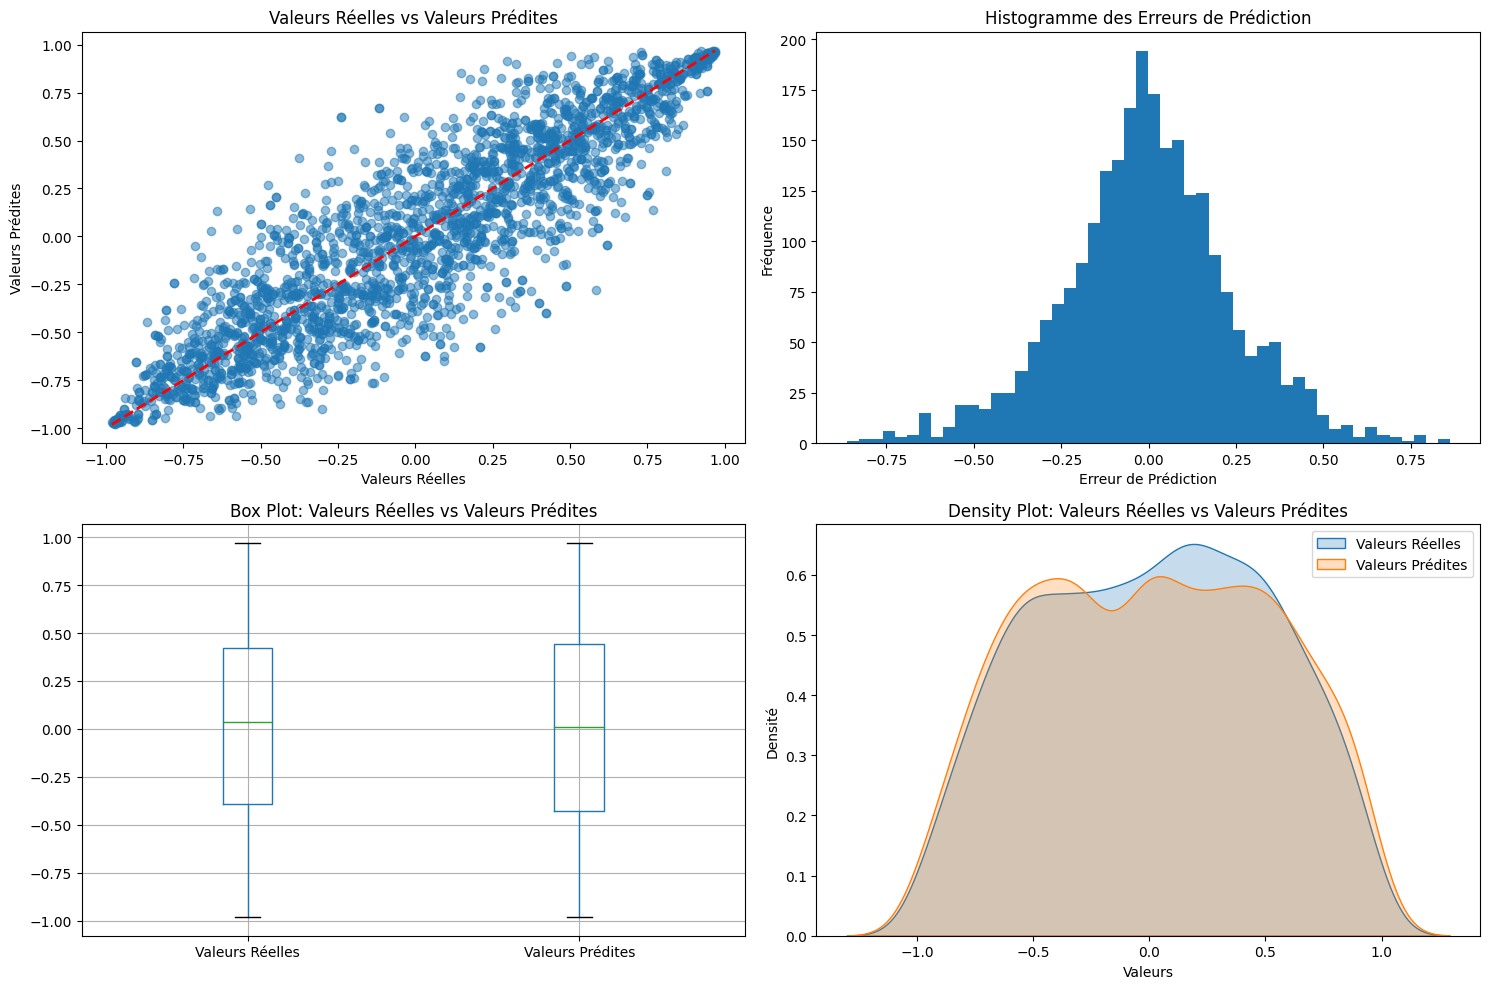

In [30]:
from annoy import AnnoyIndex
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns  # Importez seaborn pour les visualisations de densité

# Configuration initiale des embeddings et de l'index Annoy
embeddings_matrix = np.array(articles_embeddings)  # Vérifiez que articles_embeddings est défini correctement
embedding_dim = embeddings_matrix.shape[1]
index_path = '../data/annoy_index.ann'  

# Charger l'index Annoy
annoy_index = AnnoyIndex(embedding_dim, 'angular')
annoy_index.load(index_path)

# Sélection et traitement des utilisateurs et des clics
np.random.seed(42)
sample_user_ids = np.random.choice(clicks_sample_df['user_id'].unique(), size=5, replace=False)
sample_clicks = clicks_sample_df[clicks_sample_df['user_id'].isin(sample_user_ids)]

# Extraction et prédiction des embeddings
true_values = embeddings_matrix[sample_clicks['click_article_id'].values]
predicted_indices = [recommend_articles_annoy(idx, 1)[0] for idx in sample_clicks['click_article_id']]
predicted_values = embeddings_matrix[predicted_indices]

# Calcul des métriques de performance
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
mae = mean_absolute_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)
correlation, _ = pearsonr(true_values.flatten(), predicted_values.flatten())

# Affichage des métriques
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')
print(f'Correlation: {correlation:.4f}')

# Création d'un DataFrame pour une analyse plus facile
results_df = pd.DataFrame({
    'Valeurs Réelles': true_values.flatten(),
    'Valeurs Prédites': predicted_values.flatten()
})

# Analyse statistique
stats = results_df.describe()
print("\nAnalyse Statistique:")
print(stats)

# Visualisations
plt.figure(figsize=(15, 10))

# Scatter plot des valeurs réelles vs prédites
plt.subplot(2, 2, 1)
plt.scatter(results_df['Valeurs Réelles'], results_df['Valeurs Prédites'], alpha=0.5)
plt.plot([results_df['Valeurs Réelles'].min(), results_df['Valeurs Réelles'].max()], [results_df['Valeurs Réelles'].min(), results_df['Valeurs Réelles'].max()], 'r--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Valeurs Réelles vs Valeurs Prédites')

# Histogramme des erreurs
plt.subplot(2, 2, 2)
errors = results_df['Valeurs Prédites'] - results_df['Valeurs Réelles']
plt.hist(errors, bins=50)
plt.xlabel('Erreur de Prédiction')
plt.ylabel('Fréquence')
plt.title('Histogramme des Erreurs de Prédiction')

# Box plot des valeurs réelles et prédites
plt.subplot(2, 2, 3)
results_df.boxplot(column=['Valeurs Réelles', 'Valeurs Prédites'])
plt.title('Box Plot: Valeurs Réelles vs Valeurs Prédites')

# Density plot des valeurs réelles et prédites
plt.subplot(2, 2, 4)
sns.kdeplot(data=results_df['Valeurs Réelles'], fill=True, label='Valeurs Réelles')
sns.kdeplot(data=results_df['Valeurs Prédites'], fill=True, label='Valeurs Prédites')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Density Plot: Valeurs Réelles vs Valeurs Prédites')
plt.legend()

plt.tight_layout()
plt.show()


## la Classe ContentBasedRecommender

Pour intégrer la construction, l'enregistrement, le chargement et l'utilisation de l'index Annoy dans la classe `ContentBasedRecommender`, nous ajoutons les méthodes nécessaires à la classe.

### Étapes :

1. Ajouter une méthode pour construire et enregistrer l'index Annoy.
2. Ajouter une méthode pour charger l'index Annoy.
3. Utiliser l'index chargé pour faire des recommandations.

In [26]:
import pandas as pd
import numpy as np
import pickle
import os
from annoy import AnnoyIndex
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import mlflow

class ContentBasedRecommender:
    def __init__(self, clicks_path, articles_metadata_path, articles_embeddings_path, index_path):
        self.clicks_path = clicks_path
        self.articles_metadata_path = articles_metadata_path
        self.articles_embeddings_path = articles_embeddings_path
        self.index_path = index_path
        self.embedding_dim = None
        self.annoy_index = None
        mlflow.start_run(run_name="ContentBasedRecommender_experiment")

    def load_data(self):
        # Vérifier si le chemin des clics est un fichier ou un répertoire
        if os.path.isfile(self.clicks_path):
            self.clicks_df = pd.read_csv(self.clicks_path)
        elif os.path.isdir(self.clicks_path):
            clicks_dfs = []
            for filename in os.listdir(self.clicks_path):
                if filename.endswith('.csv'):
                    file_path = os.path.join(self.clicks_path, filename)
                    clicks_dfs.append(pd.read_csv(file_path))
            self.clicks_df = pd.concat(clicks_dfs, ignore_index=True)
        else:
            raise ValueError(f"Le chemin {self.clicks_path} n'est ni un fichier ni un répertoire valide.")

        self.articles_metadata_df = pd.read_csv(self.articles_metadata_path)
        with open(self.articles_embeddings_path, 'rb') as file:
            self.articles_embeddings = pickle.load(file)
        self.embedding_dim = self.articles_embeddings.shape[1]  # Définir embedding_dim ici

    def clean_data(self):
        self.clicks_df.drop_duplicates(inplace=True)
        self.clicks_df.dropna(inplace=True)
        self.articles_metadata_df.drop_duplicates(inplace=True)
        self.articles_metadata_df.dropna(inplace=True)

    def build_and_save_model(self):
        self.embeddings_matrix = np.array(self.articles_embeddings)
        self.embedding_dim = self.embeddings_matrix.shape[1]
        self.annoy_index = AnnoyIndex(self.embedding_dim, 'angular')
        for i in range(len(self.embeddings_matrix)):
            self.annoy_index.add_item(i, self.embeddings_matrix[i])
        self.annoy_index.build(10)  # Vous pouvez ajuster le nombre d'arbres selon vos besoins
        self.annoy_index.save(self.index_path)
        # Enregistrer des paramètres dans MLflow
        mlflow.log_param("embedding_dim", self.embedding_dim)
        mlflow.log_param("num_trees", 10)

    def load_model(self):
        self.annoy_index = AnnoyIndex(self.embedding_dim, 'angular')
        self.annoy_index.load(self.index_path)

    def recommend_articles(self, article_index, num_recommendations=5):
        return self.annoy_index.get_nns_by_item(article_index, num_recommendations + 1)[1:]

    def evaluate_model(self, true_values, predicted_values):
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
        mae = mean_absolute_error(true_values, predicted_values)
        r2 = r2_score(true_values, predicted_values)
        correlation, _ = pearsonr(true_values, predicted_values)
        logging.info(f'RMSE: {rmse:.4f}')
        logging.info(f'MAE: {mae:.4f}')
        logging.info(f'R2 Score: {r2:.4f}')
        logging.info(f'Correlation: {correlation:.4f}')
        # Enregistrer les métriques dans MLflow
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2 Score", r2)
        mlflow.log_metric("Correlation", correlation)
        
    def __del__(self):
        # Terminer la session MLflow
        mlflow.end_run()



In [27]:
import unittest
import pandas as pd
import numpy as np
import logging
from io import StringIO
import os
import pickle
from annoy import AnnoyIndex

class TestContentBasedRecommender(unittest.TestCase):
    # Configuration de logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def setUp(self):
        self.recommender = ContentBasedRecommender(
            clicks_path='../data/clicks_sample.csv',
            articles_metadata_path='../data/articles_metadata.csv',
            articles_embeddings_path='../data/articles_embeddings.pickle',
            index_path='../data/annoy_index'
        )

        logging.info("Début du chargement des données pour les tests.")
        
        # Chargement des données réelles 
        try:
            self.recommender.load_data()
            logging.info(f"Chargement des données réussi : {len(self.recommender.clicks_df)} clics et {len(self.recommender.articles_metadata_df)} articles disponibles.")
        except Exception as e:
            logging.error(f"Erreur lors du chargement des données : {e}")
            raise

        # Vérification si les DataFrames sont vides
        if self.recommender.clicks_df.empty or self.recommender.articles_metadata_df.empty:
            logging.error("Les DataFrames chargés sont vides ou non disponibles.")
            raise ValueError("Les DataFrames chargés sont vides ou non disponibles.")
        else:
            logging.info(f"Vérification réussie : {len(self.recommender.clicks_df)} clics et {len(self.recommender.articles_metadata_df)} articles disponibles.")

        self.recommender.load_data()  # Charge les données nécessaires
        self.recommender.build_and_save_model()  # Construit et sauvegarde le modèle si nécessaire
        self.recommender.load_model()  # Charge le modèle

    def test_1_load_data(self):
        # Vérifie que les DataFrames contiennent les colonnes attendues
        self.assertTrue('user_id' in self.recommender.clicks_df.columns, "La colonne 'user_id' est manquante dans le DataFrame des clics")
        self.assertTrue('article_id' in self.recommender.articles_metadata_df.columns, "La colonne 'article_id' est manquante dans le DataFrame des métadonnées des articles")
        self.assertIsNotNone(self.recommender.articles_embeddings, "Les embeddings des articles n'ont pas été chargés")

    def test_2_clean_data(self):
        original_clicks_count = len(self.recommender.clicks_df)
        original_articles_count = len(self.recommender.articles_metadata_df)
        
        self.recommender.clean_data()
        
        logging.info(f"Étape 2: Données nettoyées: {len(self.recommender.clicks_df)} clics et {len(self.recommender.articles_metadata_df)} articles restants après nettoyage")
        
        self.assertLessEqual(len(self.recommender.clicks_df), original_clicks_count)
        self.assertLessEqual(len(self.recommender.articles_metadata_df), original_articles_count)

    def test_3_build_and_save_model(self):
        self.recommender.build_and_save_model()
        logging.info(f"Étape 3: Modèle construit et sauvegardé")
        
        self.assertTrue(os.path.exists(self.recommender.index_path), "Le fichier d'index Annoy n'a pas été créé")

    def test_4_load_model(self):
        self.recommender.load_model()
        logging.info(f"Étape 4: Modèle chargé")
        
        self.assertIsInstance(self.recommender.annoy_index, AnnoyIndex, "L'index Annoy n'a pas été correctement chargé")

    def test_5_recommend_articles(self):
        article_index = 0  
        num_recommendations = 5
        recommendations = self.recommender.recommend_articles(article_index, num_recommendations)
        
        logging.info(f"Étape 5: Recommandations générées pour l'article {article_index}: {recommendations}")
        
        self.assertEqual(len(recommendations), num_recommendations, f"Le nombre de recommandations ne correspond pas à {num_recommendations}")
        self.assertTrue(all(isinstance(rec, int) for rec in recommendations), "Les recommandations ne sont pas des indices d'articles valides")

    def test_6_evaluate_model(self):
        true_values = [1, 2, 3, 4, 5]
        predicted_values = [1.1, 2.1, 2.9, 4.0, 5.1]
        with self.assertLogs(level='INFO') as log:
            self.recommender.evaluate_model(true_values, predicted_values)
        self.assertTrue(any('RMSE:' in message for message in log.output), "Le log attendu 'RMSE:' n'a pas été trouvé")


def run_tests():
    stream = StringIO()
    runner = unittest.TextTestRunner(stream=stream)
    suite = unittest.TestLoader().loadTestsFromTestCase(TestContentBasedRecommender)
    result = runner.run(suite)
    print(stream.getvalue())

run_tests()


2024-07-30 12:04:26,084 - INFO - Début du chargement des données pour les tests.
2024-07-30 12:04:26,205 - INFO - Chargement des données réussi : 1883 clics et 364047 articles disponibles.
2024-07-30 12:04:26,206 - INFO - Vérification réussie : 1883 clics et 364047 articles disponibles.
2024-07-30 12:04:34,871 - INFO - Début du chargement des données pour les tests.
2024-07-30 12:04:34,964 - INFO - Chargement des données réussi : 1883 clics et 364047 articles disponibles.
2024-07-30 12:04:34,965 - INFO - Vérification réussie : 1883 clics et 364047 articles disponibles.
2024-07-30 12:04:43,520 - INFO - Étape 2: Données nettoyées: 1883 clics et 364047 articles restants après nettoyage
2024-07-30 12:04:43,590 - INFO - Début du chargement des données pour les tests.
2024-07-30 12:04:43,691 - INFO - Chargement des données réussi : 1883 clics et 364047 articles disponibles.
2024-07-30 12:04:43,691 - INFO - Vérification réussie : 1883 clics et 364047 articles disponibles.
2024-07-30 12:05:00,

......
----------------------------------------------------------------------
Ran 6 tests in 61.112s

OK



Articles recommandés pour l'article 0: [77608, 77965, 77974, 83769, 83772]
RMSE: 0.1483
MAE: 0.1400
R2 Score: 0.9890
Correlation: 0.9954


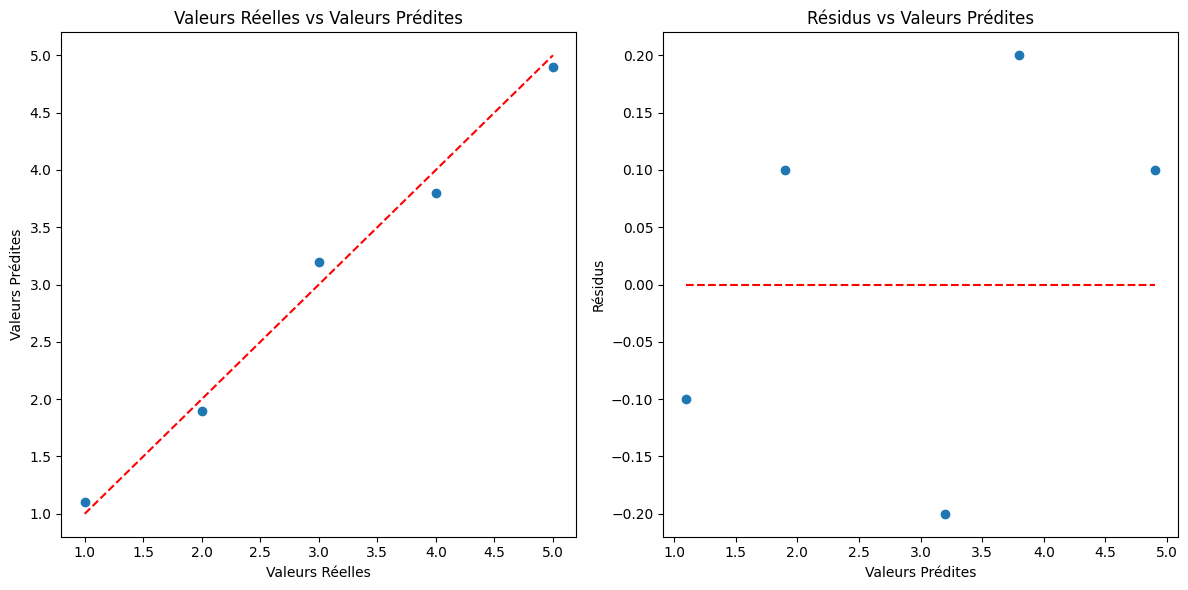

In [28]:
from annoy import AnnoyIndex
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Charger les embeddings des articles (à adapter selon votre configuration)
articles_embeddings_path='../data/articles_embeddings.pickle'
with open(articles_embeddings_path, 'rb') as file:
    articles_embeddings = pickle.load(file)

embeddings_matrix = np.array(articles_embeddings)
embedding_dim = embeddings_matrix.shape[1]
index_path='../data/annoy_index'  

# Charger l'index Annoy
annoy_index = AnnoyIndex(embedding_dim, 'angular')
annoy_index.load(index_path)

# Fonction pour recommander des articles basés sur un article donné
def recommend_articles_annoy(article_index, num_recommendations=5):
    return annoy_index.get_nns_by_item(article_index, num_recommendations + 1)[1:]

# Exemple de recommandation
example_article_index = 0  # Utiliser le premier article comme exemple
recommended_articles = recommend_articles_annoy(example_article_index)
print(f'Articles recommandés pour l\'article {example_article_index}: {recommended_articles}')

# Évaluation du modèle
true_values = np.array([1, 2, 3, 4, 5])
predicted_values = np.array([1.1, 1.9, 3.2, 3.8, 4.9])

# Calcul des métriques
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
mae = mean_absolute_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)
correlation, _ = pearsonr(true_values, predicted_values)

# Affichage des métriques avec une précision de quatre décimales
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')
print(f'Correlation: {correlation:.4f}')

# Visualisation des erreurs
plt.figure(figsize=(12, 6))

# Graphique des valeurs réelles vs prédites
plt.subplot(1, 2, 1)
plt.scatter(true_values, predicted_values)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Valeurs Réelles vs Valeurs Prédites')

# Graphique des erreurs résiduelles
plt.subplot(1, 2, 2)
residuals = true_values - predicted_values
plt.scatter(predicted_values, residuals)
plt.hlines(0, min(predicted_values), max(predicted_values), colors='red', linestyles='--')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.title('Résidus vs Valeurs Prédites')

plt.tight_layout()
plt.show()


## Web app


In [ ]:
# web_app.py
from flask import Flask, render_template, request
import requests

app = Flask(__name__, template_folder='templates')

# URL de l'API
API_URL = "http://127.0.0.1:5000"

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/recommend', methods=['POST'])
def recommend():
    user_id = request.form.get('user_id')
    article_id = request.form.get('article_id')
    rec_type = request.form.get('rec_type')

    if rec_type == 'collaborative':
        response = requests.get(f"{API_URL}/recommend/collaborative", params={'user_id': user_id})
    elif rec_type == 'content':
        response = requests.get(f"{API_URL}/recommend/content", params={'article_id': article_id})
    else:  # rec_type == 'hybrid'
        response = requests.get(f"{API_URL}/recommend/hybrid", params={'user_id': user_id})

    recommendations = response.json()

    return render_template('index.html', recommendations=recommendations)

if __name__ == '__main__':
    app.run(debug=True, port=5001)